# Denoising Autoencoder with Classification
    * Dataset- MNIST
    * Tested and Trained FrameWork-Pytorch
    * OS -Mac OS (No cuda ,Only CPU Supported)
    * Sabareeswaran Shanmugam 
    * Reference:
        *https://www.youtube.com/watch?v=6--2hc1zEZk
        *https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [1]:
import torch
torch.manual_seed(11)
import torchvision
import torchvision.transforms as transforms
import cv2
import glob
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import os
%matplotlib inline
#PATH = './sab.pth'

In [2]:
# To import the Test dataset directory to tensor
class CustomTestDirectory(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data =  glob.glob(f"{data_path}/*")
        self.transform = transform
    def __getitem__(self, index):
        img = cv2.imread(self.data[index],0)
        img = self.transform(img)
        return img, self.data[index]
    def __len__(self):
        return len(self.data)

# Transform the image to pytorch framework
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32))])  # Design to fit the Lenet input with MNIST size of 1x28x28
trainset = torchvision.datasets.MNIST(root='./Data_Assign3', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)
# Custom Test Directory
custom_testset =CustomTestDirectory('Encoder_Input',transform = transform)
test_loader_custom_directory = torch.utils.data.DataLoader(custom_testset, batch_size=1,shuffle=False, num_workers=0)

In [4]:
# Creating encoding labels to Predict the Features of MNIST.
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')


In [5]:
# Declaring the Encoder--Lenet without fc and Decoder
class LeNet_Denoising_Auto_Encoder(nn.Module):
    def __init__(self):
        super(LeNet_Denoising_Auto_Encoder, self).__init__()
        # Encoder Input
        self.encoder1 = nn.Conv2d(1, 6, 5,stride=(1,1),padding=0)    #input channel: 1, output channel: 6, filter  size is 5
        self.encoder2 = nn.Conv2d(6, 16, 5,stride=(1,1),padding=0)
        # Decoder Input
        self.decoder1 = nn.ConvTranspose2d(16, 6, 3)
        self.decoder2 = nn.ConvTranspose2d(6, 3, 3)
        # final output
        self.final_layer_output = nn.Conv2d(3, 1, 1,stride=(1,1),padding=0)
        self.reducesize1 = nn.Linear(9216, 120)
        self.reducesize2 = nn.Linear(120, 84)
        self.reducesize3 = nn.Linear(84, 10)
        self.upsampling = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.encoder1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.encoder2(x)), 2)
        #Output Image size down-sampling: decoder out
        decoder_out = F.relu(self.decoder1(x))
        decoder_out = self.upsampling(decoder_out)
        decoder_out = F.relu(self.decoder2(decoder_out))
        decoder_out = self.upsampling(decoder_out)
        decoder_out = self.final_layer_output(decoder_out)
        x = torch.flatten(x, 1)     # flatten all dimensions except the batch dimension
        x = F.relu(self.reducesize1(x))
        x = F.relu(self.reducesize2(x))
        x = self.reducesize3(x)
        return x,decoder_out
cnn_model = LeNet_Denoising_Auto_Encoder().cpu()
cnn_model

LeNet_Denoising_Auto_Encoder(
  (encoder1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (encoder2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (decoder1): ConvTranspose2d(16, 6, kernel_size=(3, 3), stride=(1, 1))
  (decoder2): ConvTranspose2d(6, 3, kernel_size=(3, 3), stride=(1, 1))
  (final_layer_output): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (reducesize1): Linear(in_features=9216, out_features=120, bias=True)
  (reducesize2): Linear(in_features=120, out_features=84, bias=True)
  (reducesize3): Linear(in_features=84, out_features=10, bias=True)
  (upsampling): Upsample(scale_factor=2.0, mode=bilinear)
)

In [6]:
# creating a MultiOptimizer and Noise Tensor
class MultipleOptimizer(object):
    def __init__(self,*op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

class SquareZeroNoise(object):
    def __init__(self, mn=0., sd=1.):
        self.sd = sd
        self.mn = mn

    def __call__(self, tensor):
        Square0 = torch.randn(tensor.size())<0
        Square0 = Square0.to(tensor.device)
        return tensor.mul(Square0)

    def __repr__(self):
        return self.__class__.__name__.format(self.mn, self.sd)

criterion = nn.CrossEntropyLoss()
L1_denoise = nn.L1Loss()
optimizer_1 = optim.SGD(cnn_model.parameters(), lr=0.0001, momentum=0.9)
optimizer_2= optim.Adam(cnn_model.parameters(), lr=0.001)
opt= MultipleOptimizer(optimizer_1,optimizer_2)
adding_noise =SquareZeroNoise(0,0.4)

## Do not run the below cell(Model already Trained) , Load the Pretrained model to evaluate the Network Result-- Thankyou

[1,  2000] loss: 11.828 
[1,  4000] loss: 4.375 
[1,  6000] loss: 2.369 
[1,  8000] loss: 1.717 
[1, 10000] loss: 1.517 
[1, 12000] loss: 1.335 
[1, 14000] loss: 1.248 
[2,  2000] loss: 1.053 
[2,  4000] loss: 1.036 
[2,  6000] loss: 1.017 
[2,  8000] loss: 0.994 
[2, 10000] loss: 0.853 
[2, 12000] loss: 0.900 
[2, 14000] loss: 0.808 
[3,  2000] loss: 0.754 
[3,  4000] loss: 0.745 
[3,  6000] loss: 0.693 
[3,  8000] loss: 0.714 
[3, 10000] loss: 0.739 
[3, 12000] loss: 0.731 
[3, 14000] loss: 0.655 
[4,  2000] loss: 0.669 
[4,  4000] loss: 0.568 
[4,  6000] loss: 0.571 
[4,  8000] loss: 0.609 
[4, 10000] loss: 0.588 
[4, 12000] loss: 0.609 
[4, 14000] loss: 0.595 
[5,  2000] loss: 0.536 
[5,  4000] loss: 0.513 
[5,  6000] loss: 0.535 
[5,  8000] loss: 0.565 
[5, 10000] loss: 0.520 
[5, 12000] loss: 0.513 
[5, 14000] loss: 0.483 
[6,  2000] loss: 0.454 
[6,  4000] loss: 0.471 
[6,  6000] loss: 0.458 
[6,  8000] loss: 0.471 
[6, 10000] loss: 0.516 
[6, 12000] loss: 0.517 
[6, 14000] loss

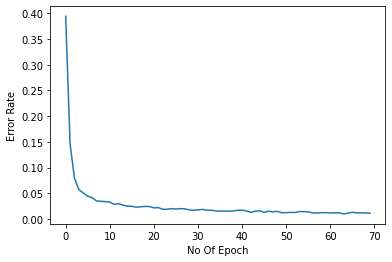

In [8]:

loss_values =[]
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    CE_loss = 0
    RE_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cpu(), labels.cpu()
        optimizer_1.zero_grad()
        # forward + backward + optimize
        outputs,decode_output = cnn_model(adding_noise(inputs))
        CE_loss = criterion(outputs, labels)
        RE_loss = L1_denoise(decode_output,inputs)
        loss = CE_loss + RE_loss
        running_loss += loss.item()
        loss.backward()
        optimizer_1.step()
        # print statistics
        running_loss += loss.item()*inputs.size(0)

        if i % 2000 == 1999:  # print every 2000 mini-batches

            print('[%d, %5d] loss: %.3f ' %
                  (epoch + 1, i + 1,   running_loss / 2000))
            loss_values.append(running_loss/len(trainset))
            running_loss = 0.0


print('Training Done')
print('Loss Curve for Pre-Trained Model')
plt.plot(loss_values)
plt.xlabel("No Of Epoch")
plt.ylabel("Error Rate")

# save the model
PATH = './lenet_encoder_sab.pth'
torch.save(cnn_model.state_dict(), PATH)

# PreTrained Model -Load and Test

# LeNet Denoising AutoEncoder -Visualization (Final Result) -by PreTrained Model

In [13]:
# Load the model
PATH = './lenet_encoder_sab.pth'

test1.png


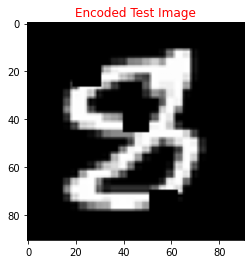

For the Given Test Image:"test1.png" ,Lenet Encorder Output classification:8


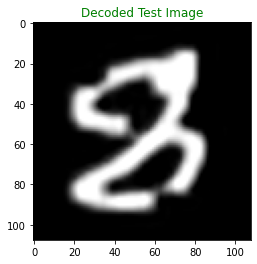

test2.png


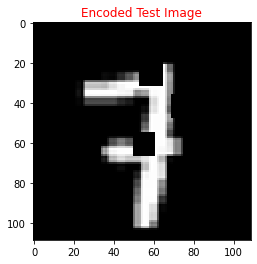

For the Given Test Image:"test2.png" ,Lenet Encorder Output classification:7


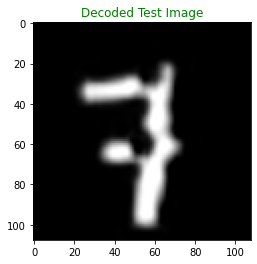

test3.png


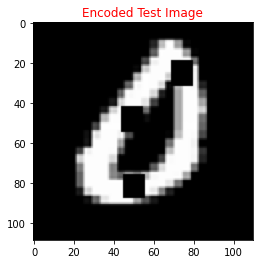

For the Given Test Image:"test3.png" ,Lenet Encorder Output classification:0


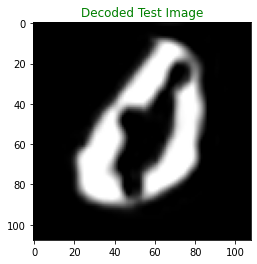

test4.png


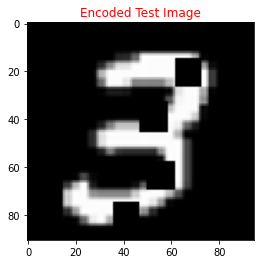

For the Given Test Image:"test4.png" ,Lenet Encorder Output classification:3


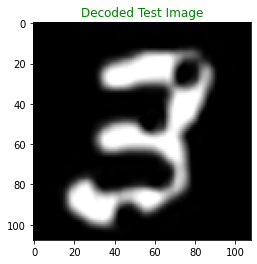

<Figure size 432x288 with 0 Axes>

In [14]:
# Loading the saved CNN Model
cnn_model = LeNet_Denoising_Auto_Encoder().cpu()
cnn_model.load_state_dict(torch.load(PATH))
cnn_model.load_state_dict(torch.load(PATH))
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
classify_res=[]
with torch.no_grad():
    for data in test_loader_custom_directory:
        images, path = data
        images = images.cpu()
        # calculate outputs by running images through the networ
        outputs, decode_output = cnn_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        name = str(path[0]).split('/')[-1]
        c_predicted= str(predicted[0]).replace("tensor(","")
        classification_results=c_predicted.replace(")","")
        classify_res.append(str('For the Given Test Image:"'+name+'" ,Lenet Encorder Output classification:' +classification_results))
        #print('For the Given Test Image:"'+name+'" ,Lenet Encorder Output classification:' +classification_results)
        save_image(decode_output, f'Decoder_Result/{name}')
classify_res.sort()

# Final result
Encorder_PATH = "./Encoder_Input/test{:1d}.png"
Decoder_PATH ="./Decoder_Result/test{:1d}.png"
for i,j in zip(range(1,5),range(1,5)):
    e=Encorder_PATH.format(i)
    image_e = mpimg.imread(e)
    print(os.path.basename(e))
    plt.gca().clear()
    plt.title('Encoded Test Image',color='red')
    plt.imshow(image_e)
    display.display(plt.gcf())
    d=Decoder_PATH.format(j)
    c=os.path.basename(d)
    for cr in classify_res:
        if c in cr:
            print(cr)
    image_d =mpimg.imread(d)
    plt.gca().clear()
    plt.title('Decoded Test Image',color='green')
    plt.imshow(image_d)
    #plt.text('Decoded Image')
    display.display(plt.gcf())
    plt.gca().clear()
plt.clf()
